In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from utils import db_connect

pd.set_option('display.max_columns', None)

engine = db_connect()

# bring in the data
main_df = pd.read_sql('SELECT * FROM combined_data', con=engine)

# function to mark whether a school was operational all five years of data
# creates our 'Currently operational' feature
def mark_always_operational(main_df):
    
    total_years = main_df['SURVYEAR'].nunique()
    
    main_df['SY_STATUS_TEXT'] = main_df['SY_STATUS_TEXT'].str.strip()
    
    operational_counts = (
        main_df[main_df['SY_STATUS_TEXT'] == 'Currently operational']
        .groupby('NCESSCH')['SURVYEAR']
        .nunique()
    )
    
    always_operational_schools = operational_counts[operational_counts == total_years].index
    
    main_df['concurrently_operational'] = main_df['NCESSCH'].isin(always_operational_schools)
    
    return main_df

# apply the function
mark_always_operational(main_df=main_df)

# drop records that were not fully operational across all five years
main_df = main_df[main_df['concurrently_operational'] != False]

# strip whitespace
for col in main_df.select_dtypes(include=["string"]).columns:
    main_df[col] = main_df[col].str.strip()

# begin defining data type conversion processes
# Change columns to floats
float_cols = ["X", "Y", "LATCOD", "LONCOD", "FTE", "STUTERATIO"]

# change columns to int
int_cols = [
    "OBJECTID", "GSLO", "GSHI",
    "TOTFRL", "FRELCH", "REDLCH", "DIRECTCERT",
    "PK", "KG", "G01", "G02", "G03", "G04", "G05", "G06",
    "G07", "G08", "G09", "G10", "G11", "G12", "G13",
    "UG", "AE",
    "TOTMENROL", "TOTFENROL", "TOTAL", "MEMBER",
    "AMALM", "AMALF", "AM",
    "ASALM", "ASALF", "AS",
    "BLALM", "BLALF", "BL",
    "HPALM", "HPALF", "HP",
    "HIALM", "HIALF", "HI",
    "TRALM", "TRALF", "TR",
    "WHALM", "WHALF", "WH"
]

# Change columns to strings
string_cols = [
    "NCESSCH", "SURVYEAR", "STABR", "LEAID", "ST_LEAID",
    "LEA_NAME", "SCH_NAME",
    "LSTREET1", "LSTREET2", "LCITY", "LSTATE",
    "LZIP", "LZIP4", "PHONE",
    "VIRTUAL", "SCHOOL_LEVEL", "SCHOOL_TYPE_TEXT",
    "STATUS", "SY_STATUS_TEXT", "ULOCALE", "NMCNTY",
    "CHARTER_TEXT", "LSTREET3", "TITLEI", "STITLEI", "MAGNET_TEXT"
]
 
# -1 or M -> Indicates that the data are missing.

# -2 or N -> Indicates that the data are not applicable.

# -9 -> Indicates that the data do not meet NCES data quality standards.

# function to clean NCES error codes
def clean_nces_error_codes(main_df, cols):
    error_values = ["M", "-1", "-9", "Missing", -1, -9
]
    main_df[cols] = main_df[cols].replace(error_values, np.nan)
    return main_df

# clean ALL columns 
cols = float_cols + int_cols + string_cols
main_df = clean_nces_error_codes(main_df, cols)

# convert floats safely
for col in float_cols:
    main_df[col] = pd.to_numeric(main_df[col], errors="coerce")

    # convert ints safely
for col in int_cols:
    main_df[col] = pd.to_numeric(main_df[col], errors="coerce").astype("Int64")

    # convert strings
for col in string_cols:
    main_df[col] = main_df[col].astype("string")

    # round coordinates
main_df["LATCOD"] = main_df["LATCOD"].round(4)
main_df["LONCOD"] = main_df["LONCOD"].round(4)

# extract start Year - convert to int for sorting
main_df['SURVYEAR'] = main_df['SURVYEAR'].str[:4].astype(int)

# removing virtual schools
main_df = main_df[main_df['VIRTUAL'].isin(['Not Virtual', 'Not a virtual school'])]

# drop the virtual feature
main_df.drop(columns='VIRTUAL', inplace=True)

# only keeping 'regular' public schools, removing: [ 'Career and Technical School',
# 'Special education school', 'Alternative Education School',
# 'Alternative/other school', 'Vocational school']
main_df = main_df[main_df['SCHOOL_TYPE_TEXT'].isin(['Regular school', 'Regular School'])]

# drop the SCHOOL_TYPE_TEXT feature
main_df.drop(columns='SCHOOL_TYPE_TEXT', inplace=True)

# replace na values with 0
main_df = main_df.fillna(0)

# Checking records against all five years
counts = main_df["NCESSCH"].value_counts()
keep_ids = counts[counts == 5].index
main_df = main_df[main_df["NCESSCH"].isin(keep_ids)].copy()

print(f"1. main_df shape: {main_df.shape}")

# Simplify ULOCALE
main_df["locale_category"] = main_df["ULOCALE"].str.split("-").str[1].str.split(":").str[0]

# Drop the ULOCALE feature because we now have our simplified locale_category feature
main_df.drop(columns='ULOCALE', inplace=True)

# Title I rough breakdown:

# Participating:
# 1 - Yes - School participates in Title I funding / programs
# 5 - Title I schoolwide school - ENTIRE school recieves Title I support. Funds can be used for all students
# 2 - Title I targeted assistance school - Only SPECIFIC eligible students recieve services (usually low-income or academically at risk)

# Eligible, but no program running:
# 4 - Title I schoolwide eligible school - no program - Enough low-income students to qualify for schoolwide funding, but not using it
# 1 - Title I targeted assistance eligible school - No program - Eligible for targeted assistance but not participating

# Hybrid
# 3 Title I schoolwide eligible - Title I targeted assitance program - School qualifies for schoolwide funding but has chosen to run only a targeted program

# Explicit non-participation
# 2 - No - School does not participate
# 6 - Not a Title I school

# 0
# 0 - Assuming missing, unknown, or not reported


# Conceptual differences:
# Schoolwide = whole school qualifies = High funding flexibility - Typical poverty threshold >= 40% low-income
# Targeted = only some students qualify = Limited funding flexibility - lower threshold for poverty

# standardize TITLEI
schoolwide = ['1-Yes', '5-Title I schoolwide school']
targeted = ['2-Title I targeted assistance school', '3-Title I schoolwide eligible-Title I targeted assistance program']
elig_no_participate = ['4-Title I schoolwide eligible school-No program', 
                       '1-Title I targeted assistance eligible school-No program']
not_elig = ['2-No', '6-Not a Title I school']
missing = [0]

def group_titlei(col_TITLEI):
    if col_TITLEI in missing:
        return "Unknown"
    elif col_TITLEI in schoolwide:
        return "Schoolwide"
    elif col_TITLEI in targeted:
        return "Targeted"
    elif col_TITLEI in elig_no_participate:
        return "Eligible_No_Program"
    elif col_TITLEI in not_elig:
        return "Not_Eligible"
    else:
        return "Error"
    
# apply the above function to main_df
main_df['TITLEI_GROUPED'] = main_df['TITLEI'].apply(group_titlei)

# standardize STITLEI
STITLEI_yes = ['1-Yes', 'Yes']
STITLEI_no = ['2-No', 'No']
STITLEI_unknown = [0]

def standardize_STITLEI(col_STITLEI):
    if col_STITLEI in STITLEI_yes:
        return 'Yes'
    elif col_STITLEI in STITLEI_no:
        return 'No'
    elif col_STITLEI in STITLEI_unknown:
        return 'Unknown'
    else:
        return 'Error'
    
# apply the above function to main_df    
main_df['STITLEI'] = main_df['STITLEI'].apply(standardize_STITLEI)

# update the contradticions between TITLEI and STITLEI (Updating the below to 'Targeted' group instead of 'Schoolwide')
main_df.loc[(main_df['TITLEI'] == '1-Yes') & (main_df['STITLEI'] == 'No'), 'TITLEI_GROUPED'] = 'Targeted'

# Checking records against all five years
counts = main_df["NCESSCH"].value_counts()
keep_ids = counts[counts == 5].index
main_df = main_df[main_df["NCESSCH"].isin(keep_ids)].copy()

print(f"2. main_df shape: {main_df.shape}")

# further filtering on positive student teacher ratios
main_df = main_df[main_df['STUTERATIO'] != 0.0]

# define additional redundant columns
redundant_cols = ['X', 'Y', 'OBJECTID', 'ST_LEAID', 'LSTREET1', 'LSTREET2', 'LSTREET3', 
                  'LZIP4', 'PHONE', 'AMALM', 'AMALF', 'ASALM', 'ASALF', 
                  'BLALM', 'BLALF', 'HPALM', 'HPALF', 'HIALM', 'HIALF', 'TRALM', 'TRALF', 
                  'WHALM', 'WHALF', 'STABR', 'LCITY', 'LSTATE', 'LZIP', 'SCHOOL_LEVEL', 'GSLO', 'GSHI'
                  , 'STATUS', 'SY_STATUS_TEXT', 'NMCNTY', 'DIRECTCERT', 'AE', 'TOTFENROL', 'TOTMENROL',
                  'concurrently_operational', 'TITLEI', 'STITLEI', 'MEMBER']

# drop additional redundant cols
main_df = main_df.drop(columns=redundant_cols)

# remove the large Alaska homeschool support program from data set
main_df[main_df['NCESSCH'] != '20013000253']

# trim the top percentile off
def trim_top_percentile(df, col="STUTERATIO", percentile=0.99):

    df = df.copy()

    # Calculate cutoff
    cutoff = df[col].quantile(percentile)

    # Count rows before trimming
    before_count = df.shape[0]

    # Trim
    df_trimmed = df[df[col] <= cutoff].copy()

    after_count = df_trimmed.shape[0]

    print(f"{percentile*100}th percentile cutoff: {cutoff:.2f}")
    print(f"Rows before: {before_count}")
    print(f"Rows after: {after_count}")
    print(f"Rows removed: {before_count - after_count}")

    print("\nTop values after trimming:")
    print(
        df_trimmed.sort_values(col, ascending=False)[
            ["NCESSCH", "SURVYEAR", "FTE", col]
        ].head(10)
    )

    return df_trimmed

# apply the above function to main_df
main_df = trim_top_percentile(main_df, col="STUTERATIO", percentile=0.99)

# trim the bottom percentile off
def trim_bottom_percentile(df, col="STUTERATIO", percentile=0.01):

    df = df.copy()

    # Calculate cutoff
    cutoff = df[col].quantile(percentile)

    # Count rows before trimming
    before_count = df.shape[0]

    # Trim bottom values
    df_trimmed = df[df[col] >= cutoff].copy()

    after_count = df_trimmed.shape[0]

    print(f"{percentile*100}th percentile cutoff: {cutoff:.2f}")
    print(f"Rows before: {before_count}")
    print(f"Rows after: {after_count}")
    print(f"Rows removed: {before_count - after_count}")

    print("\nBottom values after trimming:")
    print(
        df_trimmed.sort_values(col, ascending=True)[
            ["NCESSCH", "SURVYEAR", "FTE", col]
        ].head(10)
    )

    return df_trimmed

main_df = trim_bottom_percentile(main_df)

# create our high-strain feature
main_df["high_strain"] = (main_df["STUTERATIO"] > 20).astype(int)

# updating nces error codes to No or 0 for respective columns
values = ["N", "-2","Not applicable", "Not Applicable",-2,]
main_df.loc[main_df['CHARTER_TEXT'].isin(values), 'CHARTER_TEXT'] = 'No'
main_df.loc[main_df['MAGNET_TEXT'].isin(values), 'MAGNET_TEXT'] = 'No'
main_df.loc[main_df['FRELCH'].isin(values), 'FRELCH'] = 0
main_df.loc[main_df['REDLCH'].isin(values), 'REDLCH'] = 0

# keeping all records with 5 years of data
counts = main_df["NCESSCH"].value_counts()
keep_ids = counts[counts == 5].index
main_df = main_df[main_df["NCESSCH"].isin(keep_ids)].copy()

print(f"3. main_df shape: {main_df.shape}")

Connection successful
1. main_df shape: (202600, 80)
2. main_df shape: (202600, 81)
99.0th percentile cutoff: 28.46
Rows before: 198008
Rows after: 196028
Rows removed: 1980

Top values after trimming:
             NCESSCH  SURVYEAR        FTE  STUTERATIO
421757  390437500293      2017  13.000000       28.46
422035  390461104403      2017  17.500000       28.46
171006  320006000591      2020  56.000000       28.46
183659  350165001122      2020   9.700000       28.45
242981  120165001822      2021   7.000000       28.43
133908  470014802171      2022  15.830000       28.43
119487  390468902689      2022  18.540001       28.43
148528  271824000964      2020  26.209999       28.42
171115  320006000730      2020  62.000000       28.42
161785  370504002912      2021   7.530000       28.42
1.0th percentile cutoff: 6.00
Rows before: 196028
Rows after: 194103
Rows removed: 1925

Bottom values after trimming:
             NCESSCH  SURVYEAR        FTE  STUTERATIO
358581  301290000350      2018 

In [174]:
main_df.shape

(184405, 41)

In [175]:
main_df.head(1)

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,CHARTER_TEXT,MAGNET_TEXT,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,locale_category,TITLEI_GROUPED,high_strain
0,40168000101,2020,401680,Cartwright Elementary District (4282),Palm Lane,No,0,0,0,0,0,106,104,98,108,100,99,132,1,4,0,0,0,0,0,0,752,43.330002,17.36,9,2,30,0,683,7,21,33.4705,-112.1975,City,Schoolwide,0


<Axes: xlabel='TOTAL', ylabel='Count'>

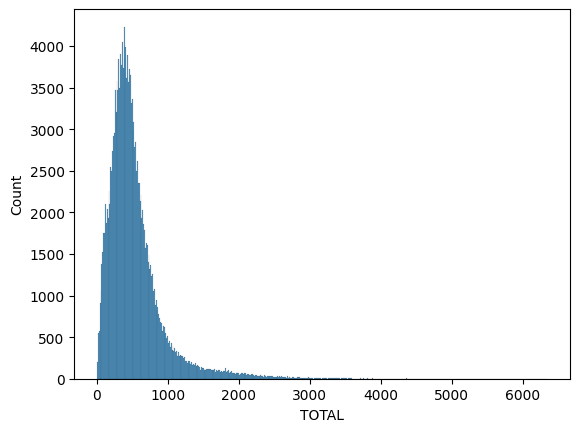

In [176]:
sns.histplot(data=main_df, x='TOTAL')

In [177]:
main_df['STUTERATIO'].describe()

count    184405.000000
mean         15.171222
std           3.464059
min           6.000000
25%          12.810000
50%          15.040000
75%          17.370000
max          28.460000
Name: STUTERATIO, dtype: float64

<Axes: xlabel='STUTERATIO', ylabel='Count'>

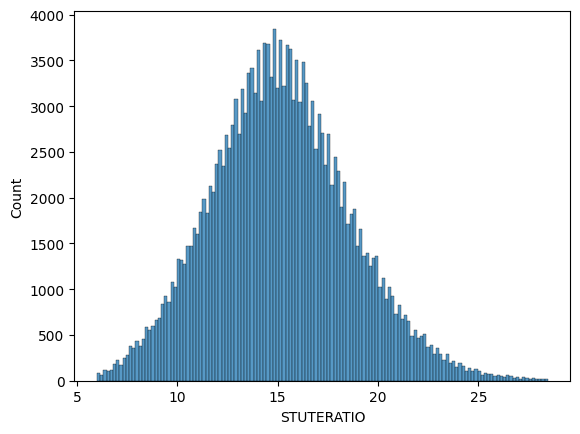

In [178]:
sns.histplot(data=main_df, x='STUTERATIO')

In [ ]:
# modeling EDA

# Do rural schools have higher strain?
# Do Title I schools have higher strain?
# Does enrollment size predict strain?
# Do funding indicators correlate?

In [179]:
print(f"main_df shape: {main_df.shape}")
print(f"high strain schools: {main_df[main_df['high_strain'] == 1].shape}")

main_df shape: (184405, 41)
high strain schools: (15768, 41)


In [180]:
main_df.head(1)

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,CHARTER_TEXT,MAGNET_TEXT,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,locale_category,TITLEI_GROUPED,high_strain
0,40168000101,2020,401680,Cartwright Elementary District (4282),Palm Lane,No,0,0,0,0,0,106,104,98,108,100,99,132,1,4,0,0,0,0,0,0,752,43.330002,17.36,9,2,30,0,683,7,21,33.4705,-112.1975,City,Schoolwide,0


In [2]:
keep_cols = ['SURVYEAR', 'LEAID', 'CHARTER_TEXT', 'MAGNET_TEXT', 'TOTFRL', 'FRELCH', 'REDLCH', 
             'PK', 'KG', 'G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08',
               'G09', 'G10', 'G11', 'G12', 'G13', 'UG', 'TOTAL', 'AM', 'AS', 'BL', 'HP', 'HI', 'TR'
               , 'WH', 'LATCOD', 'LONCOD', 'locale_category', 'TITLEI_GROUPED', 'high_strain']
refined_df = main_df[keep_cols]

In [ ]:
# for corr
subset_cols = ['high_strain', 'LEAID', 'TOTAL', 'locale_category', 'TITLEI_GROUPED']
subset_df = main_df[subset_cols]

In [28]:
subset_cols = ['TOTAL', 'AM', 'AS', 'BL', 'HP', 'HI', 'TR'
               , 'WH', 'LATCOD', 'LONCOD','high_strain', 'TOTFRL']
subset_df = main_df[subset_cols]

In [29]:
subset_df.head(1)

,TOTAL,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,high_strain,TOTFRL
37,343,0,6,23,0,14,37,263,41.2607,-76.9675,0,150


In [30]:
cat_cols = subset_df.select_dtypes(include=['category', 'object']).columns

# Keep numeric columns
num_cols = subset_df.select_dtypes(include=['number']).columns

df_encoded_full = pd.get_dummies(subset_df, columns=cat_cols)

print(df_encoded_full.head())

    TOTAL  AM  AS  BL  HP  HI  TR   WH   LATCOD   LONCOD  high_strain  TOTFRL
37    343   0   6  23   0  14  37  263  41.2607 -76.9675            0     150
38    479   0  19  35   0  17  32  376  41.2604 -76.9673            0     157
41    366   0   1   1   0   1   1  362  40.6677 -76.8273            0     134
42    358   0   1   2   0   6   5  344  40.7804 -76.6736            0     172
64    268   6  63  14   0  38  20  127  41.7723 -71.4588            0      83


In [31]:
correlation_matrix = df_encoded_full.corr()

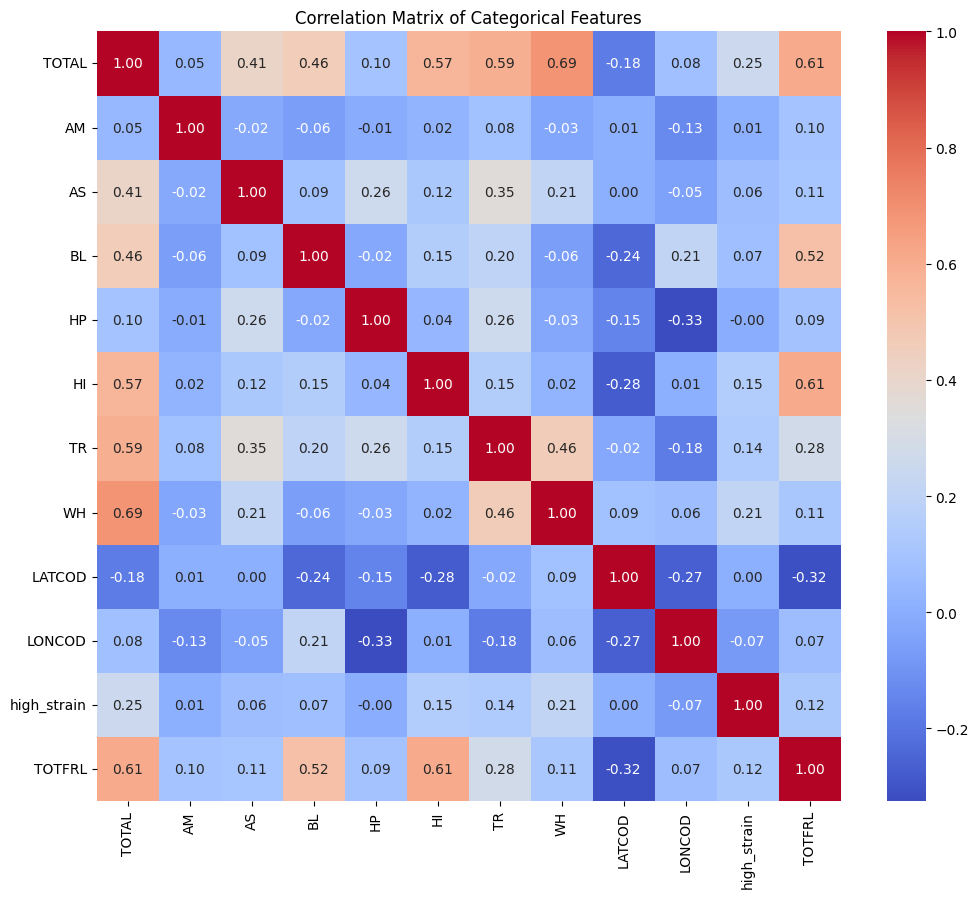

In [32]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,        # show the correlation numbers
            fmt=".2f",         # 2 decimal places
            cmap="coolwarm",   # color scheme
            cbar=True)
plt.title("Correlation Matrix of Categorical Features")
plt.show()

In [14]:
df_encoded_full.shape

(184405, 11)

In [34]:
main_df.columns

Index(['NCESSCH', 'SURVYEAR', 'LEAID', 'LEA_NAME', 'SCH_NAME', 'CHARTER_TEXT',
       'MAGNET_TEXT', 'TOTFRL', 'FRELCH', 'REDLCH', 'PK', 'KG', 'G01', 'G02',
       'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09', 'G10', 'G11', 'G12',
       'G13', 'UG', 'TOTAL', 'FTE', 'STUTERATIO', 'AM', 'AS', 'BL', 'HP', 'HI',
       'TR', 'WH', 'LATCOD', 'LONCOD', 'locale_category', 'TITLEI_GROUPED',
       'high_strain'],
      dtype='str')

# Logistic Regression preprocessing

In [ ]:
# Ethnicity proportions
for col in ['AM','AS','BL','HP','HI','TR','WH']:
    main_df[f'prop_{col}'] = main_df[col] / main_df['TOTAL']

# Grade-level ratios
main_df['upper_grades_ratio'] = main_df[['G09','G10','G11','G12','G13']].sum(axis=1) / main_df['TOTAL']
main_df['lower_grades_ratio'] = main_df[['PK','KG','G01','G02','G03','G04','G05']].sum(axis=1) / main_df['TOTAL']
main_df['middle_grades_ratio'] = main_df[['G06','G07','G08']].sum(axis=1) / main_df['TOTAL']

# Free/reduced lunch ratios
main_df['frl_ratio'] = main_df['FRELCH'] / main_df['TOTFRL']
main_df['redl_ratio'] = main_df['REDLCH'] / main_df['TOTFRL']


In [45]:
main_df.head(1)

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,CHARTER_TEXT,MAGNET_TEXT,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,locale_category,TITLEI_GROUPED,high_strain,prop_AM,prop_AS,prop_BL,prop_HP,prop_HI,prop_TR,prop_WH,upper_grades_ratio,lower_grades_ratio,middle_grades_ratio,frl_ratio,redl_ratio
13159,500927000384,2022,5009270,Windham School District,Windham Elementary School,No,0,3,3,0,3,2,7,2,6,2,0,0,0,0,0,0,0,0,0,0,22,2.01,10.95,0,0,0,0,0,0,22,43.1658,-72.7253,Rural,Unknown,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [47]:
cols_to_drop = ['AM','AS','BL','HP','HI','TR','WH', 'G06','G07','G08','G09','G10','G11','G12','G13', 'PK','KG','G01','G02','G03','G04','G05', 'TOTFRL']

In [48]:
main_df.drop(columns=cols_to_drop, inplace=True)

In [49]:
main_df.head(1)

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,CHARTER_TEXT,MAGNET_TEXT,FRELCH,REDLCH,UG,TOTAL,FTE,STUTERATIO,LATCOD,LONCOD,locale_category,TITLEI_GROUPED,high_strain,prop_AM,prop_AS,prop_BL,prop_HP,prop_HI,prop_TR,prop_WH,upper_grades_ratio,lower_grades_ratio,middle_grades_ratio,frl_ratio,redl_ratio
13159,500927000384,2022,5009270,Windham School District,Windham Elementary School,No,0,3,0,0,22,2.01,10.95,43.1658,-72.7253,Rural,Unknown,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [50]:
main_df['CHARTER_TEXT'].unique()

array(['No', 'Yes', 0], dtype=object)

In [51]:
# main_df.loc[main_df['REDLCH'].isin(values), 'REDLCH'] = 0
main_df.loc[main_df['CHARTER_TEXT'] == 0, 'CHARTER_TEXT'] = 'Missing'
main_df.loc[main_df['MAGNET_TEXT'] == 0, 'MAGNET_TEXT'] = 'Missing'

In [54]:
main_df.head(1)

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,CHARTER_TEXT,MAGNET_TEXT,FRELCH,REDLCH,UG,TOTAL,FTE,STUTERATIO,LATCOD,LONCOD,locale_category,TITLEI_GROUPED,high_strain,prop_AM,prop_AS,prop_BL,prop_HP,prop_HI,prop_TR,prop_WH,upper_grades_ratio,lower_grades_ratio,middle_grades_ratio,frl_ratio,redl_ratio
13159,500927000384,2022,5009270,Windham School District,Windham Elementary School,No,Missing,3,0,0,22,2.01,10.95,43.1658,-72.7253,Rural,Unknown,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [55]:
main_df.columns

Index(['NCESSCH', 'SURVYEAR', 'LEAID', 'LEA_NAME', 'SCH_NAME', 'CHARTER_TEXT',
       'MAGNET_TEXT', 'FRELCH', 'REDLCH', 'UG', 'TOTAL', 'FTE', 'STUTERATIO',
       'LATCOD', 'LONCOD', 'locale_category', 'TITLEI_GROUPED', 'high_strain',
       'prop_AM', 'prop_AS', 'prop_BL', 'prop_HP', 'prop_HI', 'prop_TR',
       'prop_WH', 'upper_grades_ratio', 'lower_grades_ratio',
       'middle_grades_ratio', 'frl_ratio', 'redl_ratio'],
      dtype='str')

In [60]:
main_df.drop(columns=['NCESSCH', 'SURVYEAR', 'LEA_NAME', 
                      'SCH_NAME', 'FRELCH', 'REDLCH', 'FTE', 'STUTERATIO'], inplace=True)

In [57]:
cat_cols=main_df.select_dtypes(include=['object','category']).columns
cat_cols

C:\Users\caleb\AppData\Local\Temp\ipykernel_29364\4146948189.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols=main_df.select_dtypes(include=['object','category']).columns


Index(['CHARTER_TEXT', 'MAGNET_TEXT', 'locale_category', 'TITLEI_GROUPED'], dtype='str')

In [58]:
main_df = pd.get_dummies(
    main_df,
    columns=main_df.select_dtypes(include=['object','category']).columns,
    drop_first=True
)

C:\Users\caleb\AppData\Local\Temp\ipykernel_29364\134045265.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  columns=main_df.select_dtypes(include=['object','category']).columns,


In [71]:
main_df.head(5)

,LEAID,UG,TOTAL,LATCOD,LONCOD,high_strain,prop_AM,prop_AS,prop_BL,prop_HP,prop_HI,prop_TR,prop_WH,upper_grades_ratio,lower_grades_ratio,middle_grades_ratio,frl_ratio,redl_ratio,CHARTER_TEXT_No,CHARTER_TEXT_Yes,MAGNET_TEXT_No,MAGNET_TEXT_Yes,locale_category_Rural,locale_category_Suburb,locale_category_Town,TITLEI_GROUPED_Error,TITLEI_GROUPED_Not_Eligible,TITLEI_GROUPED_Schoolwide,TITLEI_GROUPED_Targeted,TITLEI_GROUPED_Unknown
13159,5009270,0,22,43.1658,-72.7253,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,True,False,False,False,True,False,False,False,False,False,False,True
15459,5300001,0,397,47.3101,-122.0052,0,0.0,0.09068,0.020151,0.010076,0.186398,0.062972,0.629723,0.0,1.0,0.0,0.714286,0.285714,True,False,False,False,False,True,False,False,False,False,False,True
15460,5300001,0,434,47.2107,-121.9962,0,0.013825,0.004608,0.002304,0.0,0.205069,0.052995,0.721198,0.0,1.0,0.0,0.724719,0.275281,True,False,False,False,False,True,False,False,False,False,False,True
15464,5300001,0,345,47.1875,-122.0117,0,0.002899,0.0,0.008696,0.002899,0.147826,0.06087,0.776812,0.0,1.0,0.0,0.7,0.3,True,False,False,False,True,False,False,False,False,False,False,True
15465,5300001,0,400,47.2291,-122.0577,0,0.0125,0.09,0.01,0.0,0.1825,0.0575,0.6475,0.0,1.0,0.0,0.8,0.2,True,False,False,False,True,False,False,False,False,False,False,True


In [72]:
# When I did the free and reduced lunch convertions, it turned 0's into NAs so need to update to 0's
main_df.loc[main_df['frl_ratio'].isna(), 'frl_ratio'] = 0
main_df.loc[main_df['redl_ratio'].isna(), 'redl_ratio'] = 0

In [73]:
X = main_df.drop(columns=["high_strain"])
y = main_df["high_strain"]

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
# Unsure if scaling is the correct path with this dataset... might revist this with scaling.

In [76]:
main_df[main_df.isna().any(axis=1)]

,LEAID,UG,TOTAL,LATCOD,LONCOD,high_strain,prop_AM,prop_AS,prop_BL,prop_HP,prop_HI,prop_TR,prop_WH,upper_grades_ratio,lower_grades_ratio,middle_grades_ratio,frl_ratio,redl_ratio,CHARTER_TEXT_No,CHARTER_TEXT_Yes,MAGNET_TEXT_No,MAGNET_TEXT_Yes,locale_category_Rural,locale_category_Suburb,locale_category_Town,TITLEI_GROUPED_Error,TITLEI_GROUPED_Not_Eligible,TITLEI_GROUPED_Schoolwide,TITLEI_GROUPED_Targeted,TITLEI_GROUPED_Unknown


In [ ]:
# baseline logreg model
from sklearn.linear_model import LogisticRegression

base_model = LogisticRegression(max_iter=500)
base_model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [79]:
base_model_y_pred = base_model.predict(X_test)
base_model_y_prob = base_model.predict_proba(X_test)[:,1]

In [ ]:
# evaluating base logreg model
# as thought, this model is essentially guessing, with a horrible recall of actually determining strain
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, base_model_y_pred))
print("ROC AUC:", roc_auc_score(y_test, base_model_y_prob))
print(classification_report(y_test, base_model_y_pred))

Accuracy: 0.9158645372956264
ROC AUC: 0.6364782489502839
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     33727
           1       0.61      0.05      0.09      3154

    accuracy                           0.92     36881
   macro avg       0.76      0.52      0.52     36881
weighted avg       0.89      0.92      0.88     36881



In [82]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs", "liblinear"]
}

grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=500),
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train, y_train)

c:\Users\caleb\4Geeks_Capstone\4Geeks_Capstone_Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre... max_iter=500)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.01, 0.1, ...], 'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score i

In [83]:
cv_model = grid.best_estimator_
print(grid.best_params_)

{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [84]:
cv_y_pred = cv_model.predict(X_test)
cv_y_prob = cv_model.predict_proba(X_test)[:,1]

In [85]:
# evaluating best model from cv 
print("Accuracy:", accuracy_score(y_test, cv_y_pred))
print("ROC AUC:", roc_auc_score(y_test, cv_y_prob))
print(classification_report(y_test, cv_y_pred))

Accuracy: 0.6965646267725929
ROC AUC: 0.7266959014921539
              precision    recall  f1-score   support

           0       0.95      0.70      0.81     33727
           1       0.16      0.61      0.26      3154

    accuracy                           0.70     36881
   macro avg       0.56      0.66      0.53     36881
weighted avg       0.88      0.70      0.76     36881



In [86]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": cv_model.coef_[0]
}).sort_values("coef", ascending=False)

In [87]:
coef_df

,feature,coef
14,middle_grades_ratio,1.812999e-01
18,CHARTER_TEXT_Yes,1.442380e-01
22,locale_category_Suburb,8.650681e-02
11,prop_WH,7.737188e-02
12,upper_grades_ratio,6.349181e-02
27,TITLEI_GROUPED_Targeted,6.237798e-02
23,locale_category_Town,5.196614e-02
24,TITLEI_GROUPED_Error,4.177550e-02
25,TITLEI_GROUPED_Not_Eligible,2.434365e-02
2,TOTAL,1.253305e-03


In [ ]:
# interpretation to come of the above ceofficients, I still want to try 
# to scale some things out as well and see if our coefficients change at all.
# moving to looking at additional data to bring in.

Looking at additional data set for income information broken out by LEAID (school district)

In [97]:
addi_df = pd.read_csv('../data/raw/DP03_001_USSchoolDistrictAll_219154124322.txt', sep="|", dtype=str)

print(addi_df.head())
print(addi_df.shape)

              GeoId                                   Geography    LEAID  \
0  9700000US0200050          Alaska Gateway School District, AK  0200050   
1  9700000US0200010         Aleutian Region School District, AK  0200010   
2  9700000US0200007  Aleutians East Borough School District, AK  0200007   
3  9700000US0200180               Anchorage School District, AK  0200180   
4  9700000US0200525          Annette Island School District, AK  0200525   

        Year Iteration DP03_1est DP03_1moe DP03_2est DP03_2moe DP03_2pct  \
0  2018-2022       001      2043       173       982       142      48.1   
1  2018-2022       001       415       106       390       104      94.0   
2  2018-2022       001      3061        49      2415        81      78.9   
3  2018-2022       001    228369       394    159676      1574      69.9   
4  2018-2022       001      1145       118       698        88      61.0   

  DP03_2pctmoe DP03_3est DP03_3moe DP03_3pct DP03_3pctmoe DP03_4est DP03_4moe  \
0    

In [98]:
addi_df.head(1)

,GeoId,Geography,LEAID,Year,Iteration,DP03_1est,DP03_1moe,DP03_2est,DP03_2moe,DP03_2pct,DP03_2pctmoe,DP03_3est,DP03_3moe,DP03_3pct,DP03_3pctmoe,DP03_4est,DP03_4moe,DP03_4pct,DP03_4pctmoe,DP03_5est,DP03_5moe,DP03_5pct,DP03_5pctmoe,DP03_6est,DP03_6moe,DP03_6pct,DP03_6pctmoe,DP03_7est,DP03_7moe,DP03_7pct,DP03_7pctmoe,DP03_8est,DP03_8moe,DP03_9pct,DP03_9pctmoe,DP03_10est,DP03_10moe,DP03_11est,DP03_11moe,DP03_11pct,DP03_11pctmoe,DP03_12est,DP03_12moe,DP03_12pct,DP03_12pctmoe,DP03_13est,DP03_13moe,DP03_13pct,DP03_13pctmoe,DP03_14est,DP03_14moe,DP03_15est,DP03_15moe,DP03_15pct,DP03_15pctmoe,DP03_16est,DP03_16moe,DP03_17est,DP03_17moe,DP03_17pct,DP03_17pctmoe,DP03_18est,DP03_18moe,DP03_19est,DP03_19moe,DP03_19pct,DP03_19pctmoe,DP03_20est,DP03_20moe,DP03_20pct,DP03_20pctmoe,DP03_21est,DP03_21moe,DP03_21pct,DP03_21pctmoe,DP03_22est,DP03_22moe,DP03_22pct,DP03_22pctmoe,DP03_23est,DP03_23moe,DP03_23pct,DP03_23pctmoe,DP03_24est,DP03_24moe,DP03_24pct,DP03_24pctmoe,DP03_25est,DP03_25moe,DP03_26est,DP03_26moe,DP03_27est,DP03_27moe,DP03_27pct,DP03_27pctmoe,DP03_28est,DP03_28moe,DP03_28pct,DP03_28pctmoe,DP03_29est,DP03_29moe,DP03_29pct,DP03_29pctmoe,DP03_30est,DP03_30moe,DP03_30pct,DP03_30pctmoe,DP03_31est,DP03_31moe,DP03_31pct,DP03_31pctmoe,DP03_32est,DP03_32moe,DP03_33est,DP03_33moe,DP03_33pct,DP03_33pctmoe,DP03_34est,DP03_34moe,DP03_34pct,DP03_34pctmoe,DP03_35est,DP03_35moe,DP03_35pct,DP03_35pctmoe,DP03_36est,DP03_36moe,DP03_36pct,DP03_36pctmoe,DP03_37est,DP03_37moe,DP03_37pct,DP03_37pctmoe,DP03_38est,DP03_38moe,DP03_38pct,DP03_38pctmoe,DP03_39est,DP03_39moe,DP03_39pct,DP03_39pctmoe,DP03_40est,DP03_40moe,DP03_40pct,DP03_40pctmoe,DP03_41est,DP03_41moe,DP03_41pct,DP03_41pctmoe,DP03_42est,DP03_42moe,DP03_42pct,DP03_42pctmoe,DP03_43est,DP03_43moe,DP03_43pct,DP03_43pctmoe,DP03_44est,DP03_44moe,DP03_44pct,DP03_44pctmoe,DP03_45est,DP03_45moe,DP03_45pct,DP03_45pctmoe,DP03_46est,DP03_46moe,DP03_47est,DP03_47moe,DP03_47pct,DP03_47pctmoe,DP03_48est,DP03_48moe,DP03_48pct,DP03_48pctmoe,DP03_49est,DP03_49moe,DP03_49pct,DP03_49pctmoe,DP03_50est,DP03_50moe,DP03_50pct,DP03_50pctmoe,DP03_51est,DP03_51moe,DP03_52est,DP03_52moe,DP03_52pct,DP03_52pctmoe,DP03_53est,DP03_53moe,DP03_53pct,DP03_53pctmoe,DP03_54est,DP03_54moe,DP03_54pct,DP03_54pctmoe,DP03_55est,DP03_55moe,DP03_55pct,DP03_55pctmoe,DP03_56est,DP03_56moe,DP03_56pct,DP03_56pctmoe,DP03_57est,DP03_57moe,DP03_57pct,DP03_57pctmoe,DP03_58est,DP03_58moe,DP03_58pct,DP03_58pctmoe,DP03_59est,DP03_59moe,DP03_59pct,DP03_59pctmoe,DP03_60est,DP03_60moe,DP03_60pct,DP03_60pctmoe,DP03_61est,DP03_61moe,DP03_61pct,DP03_61pctmoe,DP03_62est,DP03_62moe,DP03_63est,DP03_63moe,DP03_64est,DP03_64moe,DP03_64pct,DP03_64pctmoe,DP03_65est,DP03_65moe,DP03_66est,DP03_66moe,DP03_66pct,DP03_66pctmoe,DP03_67est,DP03_67moe,DP03_68est,DP03_68moe,DP03_68pct,DP03_68pctmoe,DP03_69est,DP03_69moe,DP03_70est,DP03_70moe,DP03_70pct,DP03_70pctmoe,DP03_71est,DP03_71moe,DP03_72est,DP03_72moe,DP03_72pct,DP03_72pctmoe,DP03_73est,DP03_73moe,DP03_74est,DP03_74moe,DP03_74pct,DP03_74pctmoe,DP03_75est,DP03_75moe,DP03_76est,DP03_76moe,DP03_76pct,DP03_76pctmoe,DP03_77est,DP03_77moe,DP03_77pct,DP03_77pctmoe,DP03_78est,DP03_78moe,DP03_78pct,DP03_78pctmoe,DP03_79est,DP03_79moe,DP03_79pct,DP03_79pctmoe,DP03_80est,DP03_80moe,DP03_80pct,DP03_80pctmoe,DP03_81est,DP03_81moe,DP03_81pct,DP03_81pctmoe,DP03_82est,DP03_82moe,DP03_82pct,DP03_82pctmoe,DP03_83est,DP03_83moe,DP03_83pct,DP03_83pctmoe,DP03_84est,DP03_84moe,DP03_84pct,DP03_84pctmoe,DP03_85est,DP03_85moe,DP03_85pct,DP03_85pctmoe,DP03_86est,DP03_86moe,DP03_87est,DP03_87moe,DP03_88est,DP03_88moe,DP03_89est,DP03_89moe,DP03_90est,DP03_90moe,DP03_91est,DP03_91moe,DP03_92est,DP03_92moe,DP03_93est,DP03_93moe,DP03_94est,DP03_94moe,DP03_95est,DP03_95moe,DP03_96est,DP03_96moe,DP03_96pct,DP03_96pctmoe,DP03_97est,DP03_97moe,DP03_97pct,DP03_97pctmoe,DP03_98est,DP03_98moe,DP03_98pct,DP03_98pctmoe,DP03_99est,DP03_99moe,DP03_99pct,DP03_99pctmoe,DP03_100est,DP03_100moe,DP03_101est,DP03_101moe,DP03_101pct,DP03_101pctmoe,DP03_102est

In [99]:
addi_df.columns

Index(['GeoId', 'Geography', 'LEAID', 'Year', 'Iteration', 'DP03_1est',
       'DP03_1moe', 'DP03_2est', 'DP03_2moe', 'DP03_2pct',
       ...
       'DP03_133pct', 'DP03_133pctmoe', 'DP03_134pct', 'DP03_134pctmoe',
       'DP03_135pct', 'DP03_135pctmoe', 'DP03_136pct', 'DP03_136pctmoe',
       'DP03_137pct', 'DP03_137pctmoe'],
      dtype='str', length=443)

In [110]:
import requests

url = "https://api.census.gov/data/2022/acs/acs5/profile/groups/DP03.json"

response = requests.get(url)

print(response.status_code)  # Should be 200
print(response.headers.get('Content-Type'))  # Should indicate JSON

if response.status_code == 200:
    try:
        data = response.json()
        print(data.keys())  # Should show keys like 'variables', 'name', 'description'
    except ValueError as e:
        print("JSON decode error:", e)
        print("Response text preview:", response.text[:500])
else:
    print("Request failed with status code:", response.status_code)

200
application/json;charset=utf-8
dict_keys(['variables'])


In [121]:
variables = data['variables']

# Convert to DataFrame
var_df = pd.DataFrame.from_dict(variables, orient='index').reset_index()
var_df = var_df.rename(columns={'index': 'variable'})

In [122]:
var_df.head(1)

,variable,label,concept,predicateType,group,limit,predicateOnly
0,DP03_0053EA,Annotation of Estimate!!INCOME AND BENEFITS (I...,Selected Economic Characteristics,string,DP03,0,True


In [114]:
addi_df.head(1)

,GeoId,Geography,LEAID,Year,Iteration,DP03_1est,DP03_1moe,DP03_2est,DP03_2moe,DP03_2pct,DP03_2pctmoe,DP03_3est,DP03_3moe,DP03_3pct,DP03_3pctmoe,DP03_4est,DP03_4moe,DP03_4pct,DP03_4pctmoe,DP03_5est,DP03_5moe,DP03_5pct,DP03_5pctmoe,DP03_6est,DP03_6moe,DP03_6pct,DP03_6pctmoe,DP03_7est,DP03_7moe,DP03_7pct,DP03_7pctmoe,DP03_8est,DP03_8moe,DP03_9pct,DP03_9pctmoe,DP03_10est,DP03_10moe,DP03_11est,DP03_11moe,DP03_11pct,DP03_11pctmoe,DP03_12est,DP03_12moe,DP03_12pct,DP03_12pctmoe,DP03_13est,DP03_13moe,DP03_13pct,DP03_13pctmoe,DP03_14est,DP03_14moe,DP03_15est,DP03_15moe,DP03_15pct,DP03_15pctmoe,DP03_16est,DP03_16moe,DP03_17est,DP03_17moe,DP03_17pct,DP03_17pctmoe,DP03_18est,DP03_18moe,DP03_19est,DP03_19moe,DP03_19pct,DP03_19pctmoe,DP03_20est,DP03_20moe,DP03_20pct,DP03_20pctmoe,DP03_21est,DP03_21moe,DP03_21pct,DP03_21pctmoe,DP03_22est,DP03_22moe,DP03_22pct,DP03_22pctmoe,DP03_23est,DP03_23moe,DP03_23pct,DP03_23pctmoe,DP03_24est,DP03_24moe,DP03_24pct,DP03_24pctmoe,DP03_25est,DP03_25moe,DP03_26est,DP03_26moe,DP03_27est,DP03_27moe,DP03_27pct,DP03_27pctmoe,DP03_28est,DP03_28moe,DP03_28pct,DP03_28pctmoe,DP03_29est,DP03_29moe,DP03_29pct,DP03_29pctmoe,DP03_30est,DP03_30moe,DP03_30pct,DP03_30pctmoe,DP03_31est,DP03_31moe,DP03_31pct,DP03_31pctmoe,DP03_32est,DP03_32moe,DP03_33est,DP03_33moe,DP03_33pct,DP03_33pctmoe,DP03_34est,DP03_34moe,DP03_34pct,DP03_34pctmoe,DP03_35est,DP03_35moe,DP03_35pct,DP03_35pctmoe,DP03_36est,DP03_36moe,DP03_36pct,DP03_36pctmoe,DP03_37est,DP03_37moe,DP03_37pct,DP03_37pctmoe,DP03_38est,DP03_38moe,DP03_38pct,DP03_38pctmoe,DP03_39est,DP03_39moe,DP03_39pct,DP03_39pctmoe,DP03_40est,DP03_40moe,DP03_40pct,DP03_40pctmoe,DP03_41est,DP03_41moe,DP03_41pct,DP03_41pctmoe,DP03_42est,DP03_42moe,DP03_42pct,DP03_42pctmoe,DP03_43est,DP03_43moe,DP03_43pct,DP03_43pctmoe,DP03_44est,DP03_44moe,DP03_44pct,DP03_44pctmoe,DP03_45est,DP03_45moe,DP03_45pct,DP03_45pctmoe,DP03_46est,DP03_46moe,DP03_47est,DP03_47moe,DP03_47pct,DP03_47pctmoe,DP03_48est,DP03_48moe,DP03_48pct,DP03_48pctmoe,DP03_49est,DP03_49moe,DP03_49pct,DP03_49pctmoe,DP03_50est,DP03_50moe,DP03_50pct,DP03_50pctmoe,DP03_51est,DP03_51moe,DP03_52est,DP03_52moe,DP03_52pct,DP03_52pctmoe,DP03_53est,DP03_53moe,DP03_53pct,DP03_53pctmoe,DP03_54est,DP03_54moe,DP03_54pct,DP03_54pctmoe,DP03_55est,DP03_55moe,DP03_55pct,DP03_55pctmoe,DP03_56est,DP03_56moe,DP03_56pct,DP03_56pctmoe,DP03_57est,DP03_57moe,DP03_57pct,DP03_57pctmoe,DP03_58est,DP03_58moe,DP03_58pct,DP03_58pctmoe,DP03_59est,DP03_59moe,DP03_59pct,DP03_59pctmoe,DP03_60est,DP03_60moe,DP03_60pct,DP03_60pctmoe,DP03_61est,DP03_61moe,DP03_61pct,DP03_61pctmoe,DP03_62est,DP03_62moe,DP03_63est,DP03_63moe,DP03_64est,DP03_64moe,DP03_64pct,DP03_64pctmoe,DP03_65est,DP03_65moe,DP03_66est,DP03_66moe,DP03_66pct,DP03_66pctmoe,DP03_67est,DP03_67moe,DP03_68est,DP03_68moe,DP03_68pct,DP03_68pctmoe,DP03_69est,DP03_69moe,DP03_70est,DP03_70moe,DP03_70pct,DP03_70pctmoe,DP03_71est,DP03_71moe,DP03_72est,DP03_72moe,DP03_72pct,DP03_72pctmoe,DP03_73est,DP03_73moe,DP03_74est,DP03_74moe,DP03_74pct,DP03_74pctmoe,DP03_75est,DP03_75moe,DP03_76est,DP03_76moe,DP03_76pct,DP03_76pctmoe,DP03_77est,DP03_77moe,DP03_77pct,DP03_77pctmoe,DP03_78est,DP03_78moe,DP03_78pct,DP03_78pctmoe,DP03_79est,DP03_79moe,DP03_79pct,DP03_79pctmoe,DP03_80est,DP03_80moe,DP03_80pct,DP03_80pctmoe,DP03_81est,DP03_81moe,DP03_81pct,DP03_81pctmoe,DP03_82est,DP03_82moe,DP03_82pct,DP03_82pctmoe,DP03_83est,DP03_83moe,DP03_83pct,DP03_83pctmoe,DP03_84est,DP03_84moe,DP03_84pct,DP03_84pctmoe,DP03_85est,DP03_85moe,DP03_85pct,DP03_85pctmoe,DP03_86est,DP03_86moe,DP03_87est,DP03_87moe,DP03_88est,DP03_88moe,DP03_89est,DP03_89moe,DP03_90est,DP03_90moe,DP03_91est,DP03_91moe,DP03_92est,DP03_92moe,DP03_93est,DP03_93moe,DP03_94est,DP03_94moe,DP03_95est,DP03_95moe,DP03_96est,DP03_96moe,DP03_96pct,DP03_96pctmoe,DP03_97est,DP03_97moe,DP03_97pct,DP03_97pctmoe,DP03_98est,DP03_98moe,DP03_98pct,DP03_98pctmoe,DP03_99est,DP03_99moe,DP03_99pct,DP03_99pctmoe,DP03_100est,DP03_100moe,DP03_101est,DP03_101moe,DP03_101pct,DP03_101pctmoe,DP03_102est

In [115]:
addi_cols = addi_df.columns

In [116]:
type(addi_cols)

pandas.Index

In [117]:
addi_cols = pd.Series(addi_cols)

In [118]:
type(addi_cols)

pandas.Series

In [119]:
addi_cols = list(addi_cols)

In [120]:
type(addi_cols)

list

In [125]:
var_df[var_df['variable'].isin(addi_cols)]

,variable,label,concept,predicateType,group,limit,predicateOnly


In [ ]:
# After some research the initial data set contained the non-official, human firendly col names
# however the API call to gather the definitions are the official labels, meaning we have a mismatch,
# trying to determine a solid option for convertion

In [ ]:
import re

# suppose addi_cols = ['DP03_133pct', 'DP03_133pctmoe', ...]
mapped_cols = []
for col in addi_cols:
    # extract the number part
    m = re.search(r'DP03_(\d+)', col)
    if m:
        rownum = m.group(1).zfill(4)  # API variables are zero-padded 4 digits
        if col.endswith('pct'):
            mapped_cols.append(f'DP03_{rownum}PE')
        elif col.endswith('pctmoe'):
            mapped_cols.append(f'DP03_{rownum}M')
            
print(mapped_cols)

['DP03_0002PE', 'DP03_0002M', 'DP03_0003PE', 'DP03_0003M', 'DP03_0004PE', 'DP03_0004M', 'DP03_0005PE', 'DP03_0005M', 'DP03_0006PE', 'DP03_0006M', 'DP03_0007PE', 'DP03_0007M', 'DP03_0009PE', 'DP03_0009M', 'DP03_0011PE', 'DP03_0011M', 'DP03_0012PE', 'DP03_0012M', 'DP03_0013PE', 'DP03_0013M', 'DP03_0015PE', 'DP03_0015M', 'DP03_0017PE', 'DP03_0017M', 'DP03_0019PE', 'DP03_0019M', 'DP03_0020PE', 'DP03_0020M', 'DP03_0021PE', 'DP03_0021M', 'DP03_0022PE', 'DP03_0022M', 'DP03_0023PE', 'DP03_0023M', 'DP03_0024PE', 'DP03_0024M', 'DP03_0027PE', 'DP03_0027M', 'DP03_0028PE', 'DP03_0028M', 'DP03_0029PE', 'DP03_0029M', 'DP03_0030PE', 'DP03_0030M', 'DP03_0031PE', 'DP03_0031M', 'DP03_0033PE', 'DP03_0033M', 'DP03_0034PE', 'DP03_0034M', 'DP03_0035PE', 'DP03_0035M', 'DP03_0036PE', 'DP03_0036M', 'DP03_0037PE', 'DP03_0037M', 'DP03_0038PE', 'DP03_0038M', 'DP03_0039PE', 'DP03_0039M', 'DP03_0040PE', 'DP03_0040M', 'DP03_0041PE', 'DP03_0041M', 'DP03_0042PE', 'DP03_0042M', 'DP03_0043PE', 'DP03_0043M', 'DP03_0044PE'

In [127]:
var_df[var_df['variable'].isin(mapped_cols)]

,variable,label,concept,predicateType,group,limit,predicateOnly
6,DP03_0048PE,Percent!!CLASS OF WORKER!!Civilian employed po...,Selected Economic Characteristics,float,DP03,0,True
13,DP03_0022PE,Percent!!COMMUTING TO WORK!!Workers 16 years a...,Selected Economic Characteristics,float,DP03,0,True
16,DP03_0111PE,Percent!!HEALTH INSURANCE COVERAGE!!Civilian n...,Selected Economic Characteristics,float,DP03,0,True
23,DP03_0035PE,Percent!!INDUSTRY!!Civilian employed populatio...,Selected Economic Characteristics,float,DP03,0,True
24,DP03_0107M,Margin of Error!!HEALTH INSURANCE COVERAGE!!Ci...,Selected Economic Characteristics,int,DP03,0,True
...,...,...,...,...,...,...,...
1076,DP03_0053M,Margin of Error!!INCOME AND BENEFITS (IN 2022 ...,Selected Economic Characteristics,int,DP03,0,True
1077,DP03_0052M,Margin of Error!!INCOME AND BENEFITS (IN 2022 ...,Selected Economic Characteristics,int,DP03,0,True
1085,DP03_0050M,Margin of Error!!CLASS OF WORKER!!Civilian emp...,Selected Economic Characteristics,int,DP03,0,True
1089,DP03_0115PE,Percent!!HEALTH INSURANCE COVERAGE!!Civilian n...,Selected Economic Characteristics,float,DP03,0,True


In [128]:
# Success!

In [129]:
pd.set_option('display.max_rows', None)

In [130]:
var_df[var_df['variable'].isin(mapped_cols)]

,variable,label,concept,predicateType,group,limit,predicateOnly
6,DP03_0048PE,Percent!!CLASS OF WORKER!!Civilian employed po...,Selected Economic Characteristics,float,DP03,0,True
13,DP03_0022PE,Percent!!COMMUTING TO WORK!!Workers 16 years a...,Selected Economic Characteristics,float,DP03,0,True
16,DP03_0111PE,Percent!!HEALTH INSURANCE COVERAGE!!Civilian n...,Selected Economic Characteristics,float,DP03,0,True
23,DP03_0035PE,Percent!!INDUSTRY!!Civilian employed populatio...,Selected Economic Characteristics,float,DP03,0,True
24,DP03_0107M,Margin of Error!!HEALTH INSURANCE COVERAGE!!Ci...,Selected Economic Characteristics,int,DP03,0,True
28,DP03_0066PE,Percent!!INCOME AND BENEFITS (IN 2022 INFLATIO...,Selected Economic Characteristics,float,DP03,0,True
30,DP03_0108M,Margin of Error!!HEALTH INSURANCE COVERAGE!!Ci...,Selected Economic Characteristics,int,DP03,0,True
35,DP03_0105M,Margin of Error!!HEALTH INSURANCE COVERAGE!!Ci...,Selected Economic Characteristics,int,DP03,0,True
38,DP03_0106M,Margin of Error!!HEALTH INSURANCE COVERAGE!!Ci...,Selected Economic Characteristics,int,DP03,0,True
42,DP03_0079PE,Percent!!INCOME AND BENEFITS (IN 2022 INFLATIO...,Selected Economic Characteristics,float,DP03,0,True
